In [1]:
#Cleaned Up Form of Analysis Code Pulled from Yuqi's archive

#Preliminary Setup
import os
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import numpy.matlib as npmat
import random
from scipy.stats import ttest_ind, sem, chi2, pearsonr, spearmanr
from statsmodels.stats.multitest import multipletests

red = (214/255, 33/255, 98/255)
blue = (71/255, 124/255, 191/255)

# Get the current working directory
current_directory = os.getcwd()
print(f"Current Directory is: {current_directory}. This script will save data into a 'Running_Python_Outputs' folder within it.")

folder_name = "Running_Python_Outputs"
save_path=os.path.join(current_directory,folder_name)

if not os.path.isdir(save_path): 
    os.mkdir(save_path)

# Load the Excel file
folder_name = "Original_Yuqi_DataSheets"
data_folder_path=os.path.join(current_directory,folder_name)
if not os.path.isdir(data_folder_path): 
    print(f"Folder of LightSheet Data does not exist at {data_folder_path} -- Check that you have data at the proper location")
file_path=os.path.join(data_folder_path,"NeuN_Abeta_corrToRob_removeextrasub.xlsx")                                  
data = pd.read_excel(file_path)

val=data['Shorts']=='cn7'
true_indices = [i for i, val in enumerate(val) if val is True]

for i, true_idx in enumerate(true_indices):
    data.loc[true_indices[i], 'Shorts']='FMN'
    data.loc[true_indices[i], 'Structure']='FMN__Facial_motor_nucleus_left'
    
# Create NeuN_num column
data['NeuN_num'] = data['NeuNDensity_Mean'] * 1000 * data['volume_mm3']

regions =['BLA', 'VCP', 'VCS','AON','PIC','CA3', 'EPF','SUB','ACC','CA1','NAC','LSN','SUT','FMN','HGN','PFT','MGD','RED','AVT','POT','cst','mel']
targets = ['volume_mm3','NeuN_num','NeuNDensity_Mean', 'Abeta_Mean'] 

Current Directory is: /Users/kjh60/Desktop. This script will save data into a 'Running_Python_Outputs' folder within it.


In [2]:
data.head()

,Specimen,Gene_condition,Region,NeuNDensity_Mean,centroid_PA,Structure,Shorts,volume_mm3,fa_mean,ad_mean,rd_mean,md_mean,Abeta_Mean,sex,NeuN_num
0,220114-10_1,AD,9,76.066667,2.333553,ACC__Anterior_cingulate_cortex_left,ACC,2.632172,0.166544,0.315181,0.252126,0.273145,0.065336,F,200220.550133
1,220114-11_1,Non-AD,9,107.433333,2.333553,ACC__Anterior_cingulate_cortex_left,ACC,2.304641,0.214492,0.371017,0.274356,0.306576,0.028827,F,247595.264767
2,220114-12_1,Non-AD,9,118.600000,2.333553,ACC__Anterior_cingulate_cortex_left,ACC,2.429500,0.196529,0.301901,0.231915,0.255244,0.024727,M,288138.700000
3,220114-13_1,AD,9,103.000000,2.333553,ACC__Anterior_cingulate_cortex_left,ACC,2.349547,0.166307,0.328804,0.261665,0.284044,0.052467,M,242003.341000
4,220114-18_1,AD,9,85.800000,2.333553,ACC__Anterior_cingulate_cortex_left,ACC,2.513016,0.191180,0.423927,0.322602,0.356377,0.045233,F,215616.772800


In [3]:
# Helper Functions

def fisher_combined(individual_p_values):
    chi2_stat = -2 * np.sum(np.log(individual_p_values))
    combined_p_value = chi2.sf(chi2_stat, 2 * len(individual_p_values))
    return combined_p_value

def correlation(x,y,x_name,y_name,corr_type,delineation_name):
    if corr_type == 'spearman':
        rho, pval = spearmanr(x, y)

        entry = {'x_metric': x_name,
            'y_metric': y_name,
            'additional_delineation': delineation_name,
            'correlation type': 'spearman',
            'rho': rho,
            'pvalue': pval
        }
    if corr_type == 'pearson':
        r, pval = pearsonr(x, y)

        entry = {'x_metric': x_name,
            'y_metric': y_name,
            'additional_delineation': delineation_name,
            'correlation type': 'pearson',
            'r': r,
            'pvalue': pval
        }
    return entry

def make_summary_table (grouped):
    pivoted = grouped.pivot(index='Region', columns='Gene_condition')
    
    change_df = pd.DataFrame({
    'Volume_change': (pivoted['Volume']['Tg'] - pivoted['Volume']['nTg']),
    'Volume_normalized_change': (pivoted['volume_normalized']['Tg'] - pivoted['volume_normalized']['nTg']),
    'Neuron_Density_change': (pivoted['Neuron_Density']['Tg'] - pivoted['Neuron_Density']['nTg']),
    'Neuron_Number_change': (pivoted['Neuron_Number']['Tg'] - pivoted['Neuron_Number']['nTg']),
    'Abeta_load_Tg': pivoted['Abeta_load']['Tg']
}).dropna()
    
    return change_df 

In [4]:
#Create Pvalues for t-test and percent changes

individual_p_values = []
data_keep = [{}]
data_keep_fa=[{}]
regions_num=[]
for con, target in enumerate(targets):
    relative_diff = []
    relative_diff_sem = []  # For error bars
    relative_foldchange_sem = []
    
    for i, region in enumerate(regions):
        # Filter data for AD and Non-AD groups for the current region
        non_ad_data = data[(data['Shorts'] == region) & (data['Gene_condition'] == 'Non-AD')][target]
        ad_data = data[(data['Shorts'] == region) & (data['Gene_condition'] == 'AD')][target]
    
        structure_name= data['Structure'][(data['Shorts'] == region) & (data['Gene_condition'] == 'AD')].unique()

        ad_mean = np.mean(ad_data)
        non_ad_mean = np.mean(non_ad_data)
        
        ad_std = np.std(ad_data)
        non_ad_std = np.std(non_ad_data)

        if non_ad_mean != 0:  # Avoid division by zero
            diff = (ad_mean - non_ad_mean) / non_ad_mean
            relative_diff.append(diff)
            # SEM calculation
            combined_data = (ad_data - non_ad_data.mean()) / non_ad_mean
            relative_diff_sem.append(sem(combined_data, nan_policy='omit'))
            
            combined_data_FoldChange = []
            num = np.array(ad_data)
            denom = np.array(non_ad_data)
            for i in range(len(denom)):
                combined_data_FoldChange.append(num/denom[i])
                tempFC=np.array(combined_data_FoldChange) 
                relative_foldchange_sem.append(np.std(tempFC)/(np.sqrt(len(num)*len(denom))))
        
        else:
            relative_diff.append(np.nan)
            relative_diff_sem.append(np.nan)
            
        if len(ad_data) > 0 and len(non_ad_data) > 0:
            # t-test
            t_stat, p_value = ttest_ind(ad_data, non_ad_data, nan_policy='omit', equal_var=False)
            individual_p_values.append(p_value)
            pvalf=p_value
        else:
            individual_p_values.append(np.nan)
            pvalf=np.nan
               
        if target == 'volume_mm3':
            temp=data[(data['Shorts'] == region) & (data['Gene_condition'] == 'AD')]
            FAD_fa_data=data[(data['Shorts'] == region) & (data['Gene_condition'] == 'AD')]['fa_mean']
            nTG_fa_data=data[(data['Shorts'] == region) & (data['Gene_condition'] == 'Non-AD')]['fa_mean']

            regions_num.append(temp['Region'].unique())
            
            FAD_fa_data_mean = np.mean(FAD_fa_data)
            nTG_fa_data_mean = np.mean(nTG_fa_data)

            fa_diff = (FAD_fa_data_mean - nTG_fa_data_mean) / nTG_fa_data_mean
            # SEM calculation
            fa_diff_2 = (FAD_fa_data - nTG_fa_data_mean) / nTG_fa_data_mean # how each FAD varies from mean nTG 
            
            combined_FA_PerChange = []
            num = np.array(ad_data)
            denom = np.array(non_ad_data)
            for i in range(len(denom)):
                combined_FA_PerChange.append((num-denom[i])/denom[i])
                tempPC_FA=np.array(combined_FA_PerChange)           

            entry_fa={'Structure': str("").join(structure_name),'Abbreviation': region,'Relative_Diff FA wrt nTG':fa_diff,'SEM --indiv2indiv':np.std(tempPC_FA)/(np.sqrt(len(num)*len(denom)))} # Yuqi sem is equvilant to np.std(fa_diff_2)/np.sqrt(8)) -- why 8 and not 7 or 9? 
            data_keep_fa.append(entry_fa)

        entry = {'Structure': str("").join(structure_name),'Abbreviation': region, 'Contrast': target, 'T-Stat': t_stat,'Pvalue':pvalf, 'Relative_Diff wrt nTG': diff,'Mean Fold-Change':ad_mean/non_ad_mean,'SEM --indiv2indiv_sameforfold&percent':np.std(tempFC)/(np.sqrt(len(num)*len(denom))), 'FAD_mean': ad_mean,'NTg_mean':non_ad_mean,'FAD_std': ad_std,'NTg_std':non_ad_std}
        data_keep.append(entry)
        

df_fa=pd.DataFrame(data_keep_fa)
df_fa = df_fa[1:] #cleans out preallocation row
df_fa.to_csv('/Users/kjh60/Dropbox/5XFAD_Phasei/Checking_Yuqi_Data/Running_Python_Outputs/Saved_PerChange_FA_for_Figure6i.csv', index=True)
                          
df = pd.DataFrame(data_keep)
df = df[1:] #cleans out preallocation row

H0, Pvalue_BH,Sidak_Alpha,Bonferroni_Alpha=multipletests(individual_p_values, alpha=0.05, method='fdr_bh')
df.insert(loc=5, column='Pvalue_BH', value=Pvalue_BH)

H0, Pvalue_Bonferroni,Sidak_Alpha,Bonferroni_Alpha=multipletests(individual_p_values, alpha=0.05, method='bonferroni')
df.insert(loc=5, column='Pvalue_Bonferroni', value=Pvalue_Bonferroni)

save_path_data=os.path.join(save_path,"Saved_T_Test_Results_for_Figure6.csv")
df.to_csv(save_path_data, index=True)

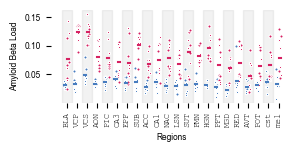

In [5]:
## Amyloid Beta -- indiv plot
# Set plotting target
target = 'Abeta_Mean'
target_ylabel = 'Amyloid Beta Load'

# Colors
ntg_color = blue
tg_color = red

# Prepare figure for plotting
plt.rcParams.update({'font.size': 6, 'font.family': 'Arial'})
plt.rcParams['text.usetex'] = False
plt.rcParams['svg.fonttype'] = 'none'  # Keep SVG text editable

fig, ax = plt.subplots(figsize=(3, 1.5))
ax.set_frame_on(False)

# Plot background bands
for i in range(len(regions)):
    if i % 2 == 0:
        ax.axvspan(i + 0.5, i + 1.5, color='gray', alpha=0.1)

# Plot data for each region
for i, region in enumerate(regions):
    tg_data = data[(data['Shorts'] == region) & (data['Gene_condition'] == 'AD')][target]
    ntg_data = data[(data['Shorts'] == region) & (data['Gene_condition'] == 'Non-AD')][target]
        
    tg_data_F = data[(data['Shorts'] == region) & (data['Gene_condition'] == 'AD') & (data['sex']=='F')][target]
    tg_data_M = data[(data['Shorts'] == region) & (data['Gene_condition'] == 'AD') & (data['sex']=='M')][target]
    ntg_data_F = data[(data['Shorts'] == region) & (data['Gene_condition'] == 'Non-AD')& (data['sex']=='F')][target]
    ntg_data_M = data[(data['Shorts'] == region) & (data['Gene_condition'] == 'Non-AD')& (data['sex']=='M')][target]

    jitter = lambda: random.uniform(-0.1, 0.1)
        
    # Plot NTg points
    ax.scatter([i + 0.85 + jitter() for _ in ntg_data_F], ntg_data_F,s=5,  marker='o', color=ntg_color, linewidths=0.75, edgecolor='w',
               label='NTg' if i == 0 else "", alpha=1)

    ax.scatter([i + 0.85 + jitter() for _ in ntg_data_M], ntg_data_M,s=4,  marker='s', color=ntg_color, linewidths=0.75, edgecolor='w',
               label='NTg' if i == 0 else "", alpha=1)
        
    # Plot Tg points
    ax.scatter([i + 1.15 + jitter() for _ in tg_data_F], tg_data_F,s=5, marker='o',color=tg_color,linewidths=0.75, edgecolor='w',
               label='Tg' if i == 0 else "", alpha=1)
    ax.scatter([i + 1.15 + jitter() for _ in tg_data_M], tg_data_M,s=4, marker='s',color=tg_color,linewidths=0.75, edgecolor='w',
                   label='Tg' if i == 0 else "", alpha=1)
        

    # Plot group means
    if len(ntg_data) > 0:
        ax.plot([i + 0.75, i + 0.95], [ntg_data.mean()] * 2, color=blue, linewidth=1.5)
    if len(tg_data) > 0:
        ax.plot([i + 1.05, i + 1.25], [tg_data.mean()] * 2, color=red, linewidth=1.5) 

    # Optional: compute and display p-value
    if len(ntg_data) > 0 and len(tg_data) > 0:
        _, p_value = ttest_ind(ntg_data, tg_data, nan_policy='omit')
        # Uncomment if you want to show p-values:
        # ax.text(i + 1, max(max(tg_data), max(ntg_data)) + 5, f'p={p_value:.3f}', ha='center', fontsize=7, color='red')

# Customize plot appearance
ax.set_xticks(np.arange(len(regions)) + 1)
ax.set_xticklabels(regions, rotation=90,fontname='Courier New')
ax.set_xlabel('Regions')
ax.set_ylabel(target_ylabel)
#ax.legend() -- legends don't go on graphs for journals typically

# Save the figure
save_path_fig=os.path.join(save_path,"Indiv_ABeta_Dots_2025_11_04.svg")
plt.savefig(save_path_fig, dpi=600)

# Display plot
plt.tight_layout()
plt.show()

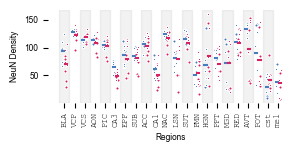

In [6]:
## NeuN Density -- indiv plot
# Set plotting target
target = 'NeuNDensity_Mean'
target_ylabel = 'NeuN Density'

# Colors
ntg_color = blue
tg_color = red

# Prepare figure for plotting
plt.rcParams.update({'font.size': 6, 'font.family': 'Arial'})
plt.rcParams['text.usetex'] = False
plt.rcParams['svg.fonttype'] = 'none'  # Keep SVG text editable

fig, ax = plt.subplots(figsize=(3, 1.5))
ax.set_frame_on(False)

# Plot background bands
for i in range(len(regions)):
    if i % 2 == 0:
        ax.axvspan(i + 0.5, i + 1.5, color='gray', alpha=0.1)

# Plot data for each region
for i, region in enumerate(regions):
    tg_data = data[(data['Shorts'] == region) & (data['Gene_condition'] == 'AD')][target]
    ntg_data = data[(data['Shorts'] == region) & (data['Gene_condition'] == 'Non-AD')][target]
        
    tg_data_F = data[(data['Shorts'] == region) & (data['Gene_condition'] == 'AD') & (data['sex']=='F')][target]
    tg_data_M = data[(data['Shorts'] == region) & (data['Gene_condition'] == 'AD') & (data['sex']=='M')][target]
    ntg_data_F = data[(data['Shorts'] == region) & (data['Gene_condition'] == 'Non-AD')& (data['sex']=='F')][target]
    ntg_data_M = data[(data['Shorts'] == region) & (data['Gene_condition'] == 'Non-AD')& (data['sex']=='M')][target]

    jitter = lambda: random.uniform(-0.1, 0.1)
        
    # Plot NTg points
    ax.scatter([i + 0.85 + jitter() for _ in ntg_data_F], ntg_data_F,s=5,  marker='o', color=ntg_color, linewidths=0.75, edgecolor='w',
               label='NTg' if i == 0 else "", alpha=1)

    ax.scatter([i + 0.85 + jitter() for _ in ntg_data_M], ntg_data_M,s=4,  marker='s', color=ntg_color, linewidths=0.75, edgecolor='w',
               label='NTg' if i == 0 else "", alpha=1)
        
    # Plot Tg points
    ax.scatter([i + 1.15 + jitter() for _ in tg_data_F], tg_data_F,s=5, marker='o',color=tg_color,linewidths=0.75, edgecolor='w',
               label='Tg' if i == 0 else "", alpha=1)
    ax.scatter([i + 1.15 + jitter() for _ in tg_data_M], tg_data_M,s=4, marker='s',color=tg_color,linewidths=0.75, edgecolor='w',
                   label='Tg' if i == 0 else "", alpha=1)
        

    # Plot group means
    if len(ntg_data) > 0:
        ax.plot([i + 0.75, i + 0.95], [ntg_data.mean()] * 2, color=blue, linewidth=1.5)
    if len(tg_data) > 0:
        ax.plot([i + 1.05, i + 1.25], [tg_data.mean()] * 2, color=red, linewidth=1.5) 

    # Optional: compute and display p-value
    if len(ntg_data) > 0 and len(tg_data) > 0:
        _, p_value = ttest_ind(ntg_data, tg_data, nan_policy='omit')
        # Uncomment if you want to show p-values:
        # ax.text(i + 1, max(max(tg_data), max(ntg_data)) + 5, f'p={p_value:.3f}', ha='center', fontsize=7, color='red')

# Customize plot appearance
ax.set_xticks(np.arange(len(regions)) + 1)
ax.set_xticklabels(regions, rotation=90,fontname='Courier New')
ax.set_xlabel('Regions')
ax.set_ylabel(target_ylabel)
#ax.legend() -- legends don't go on graphs for journals typically

# Save the figure
save_path_fig=os.path.join(save_path,"Indiv_NeuNDensity_Mean_Dots_2025_11_04.svg")
plt.savefig(save_path_fig, dpi=600)


# Display plot
plt.tight_layout()
plt.show()

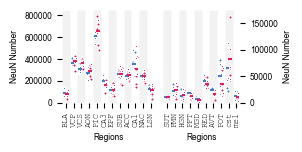

In [7]:
## NeuN Number -- indiv plot
# Set plotting target
target = 'NeuN_num'
target_ylabel = 'NeuN Number'
range_num=12

# Colors
ntg_color = blue
tg_color = red

# Prepare figure for plotting
plt.rcParams.update({'font.size': 6, 'font.family': 'Arial'})
plt.rcParams['text.usetex'] = False
plt.rcParams['svg.fonttype'] = 'none'  # Keep SVG text editable

fig, (ax, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(3, 1.5),gridspec_kw={'width_ratios': [12/10, 1]})
ax.set_frame_on(False)
ax2.set_frame_on(False)

# Plot background bands
for i in range(len(regions)):
        if i % 2 == 0:
            ax.axvspan(i + 0.5, i + 1.5, facecolor='gray', edgecolor='w', alpha=0.1)
            ax2.axvspan(i + 0.5, i + 1.5, facecolor='gray',edgecolor='w', alpha=0.1)
            

# Plot data for each region
for i, region in enumerate(regions):
    tg_data = data[(data['Shorts'] == region) & (data['Gene_condition'] == 'AD')][target]
    ntg_data = data[(data['Shorts'] == region) & (data['Gene_condition'] == 'Non-AD')][target]

    tg_data_F = data[(data['Shorts'] == region) & (data['Gene_condition'] == 'AD') & (data['sex']=='F')][target]
    tg_data_M = data[(data['Shorts'] == region) & (data['Gene_condition'] == 'AD') & (data['sex']=='M')][target]
    ntg_data_F = data[(data['Shorts'] == region) & (data['Gene_condition'] == 'Non-AD')& (data['sex']=='F')][target]
    ntg_data_M = data[(data['Shorts'] == region) & (data['Gene_condition'] == 'Non-AD')& (data['sex']=='M')][target]
        
    if i < 12:

        jitter = lambda: random.uniform(-0.1, 0.1)

        # Plot NTg points
        ax.scatter([i + 0.85 + jitter() for _ in ntg_data_F], ntg_data_F,s=5,  marker='o', color=ntg_color, linewidths=0.75, edgecolor='w',
                   label='NTg' if i == 0 else "", alpha=1)

        ax.scatter([i + 0.85 + jitter() for _ in ntg_data_M], ntg_data_M,s=4,  marker='s', color=ntg_color, linewidths=0.75, edgecolor='w',
                   label='NTg' if i == 0 else "", alpha=1)

        # Plot Tg points
        ax.scatter([i + 1.15 + jitter() for _ in tg_data_F], tg_data_F,s=5, marker='o',color=tg_color,linewidths=0.75, edgecolor='w',
                   label='Tg' if i == 0 else "", alpha=1)
        ax.scatter([i + 1.15 + jitter() for _ in tg_data_M], tg_data_M,s=4, marker='s',color=tg_color,linewidths=0.75, edgecolor='w',
                       label='Tg' if i == 0 else "", alpha=1)    

        # Plot group means
        if len(ntg_data) > 0:
            ax.plot([i + 0.75, i + 0.95], [ntg_data.mean()] * 2, color=blue, linewidth=1.5)
        if len(tg_data) > 0:
            ax.plot([i + 1.05, i + 1.25], [tg_data.mean()] * 2, color=red, linewidth=1.5) 
    else:
        jitter = lambda: random.uniform(-0.1, 0.1)

        # Plot NTg points
        ax2.scatter([i-(range_num) + 0.85 + jitter() for _ in ntg_data_F], ntg_data_F,s=5,  marker='o', color=ntg_color, linewidths=0.75, edgecolor='w',
                   label='NTg' if i == 0 else "", alpha=1)

        ax2.scatter([i-(range_num)+ 0.85 + jitter() for _ in ntg_data_M], ntg_data_M,s=4,  marker='s', color=ntg_color, linewidths=0.75, edgecolor='w',
                   label='NTg' if i == 0 else "", alpha=1)

        # Plot Tg points
        ax2.scatter([i-(range_num) + 1.15 + jitter() for _ in tg_data_F], tg_data_F,s=5, marker='o',color=tg_color,linewidths=0.75, edgecolor='w',
                   label='Tg' if i == 0 else "", alpha=1)
        ax2.scatter([i-(range_num) + 1.15 + jitter() for _ in tg_data_M], tg_data_M,s=4, marker='s',color=tg_color,linewidths=0.75, edgecolor='w',
                       label='Tg' if i == 0 else "", alpha=1)    

        # Plot group means
        if len(ntg_data) > 0:
            ax2.plot([i-(range_num) + 0.75, i-(range_num) + 0.95], [ntg_data.mean()] * 2, color=blue, linewidth=1.5)
        if len(tg_data) > 0:
            ax2.plot([i-(range_num) + 1.05, i-(range_num) + 1.25], [tg_data.mean()] * 2, color=red, linewidth=1.5) 
        

# Customize plot appearance
ax.set_xticks(np.arange(len(regions[0:(range_num)]))+1)
ax.set_xticklabels(regions[0:(range_num)], rotation=90,fontname='Courier New')
ax.set_xlabel('Regions')
ax.set_ylabel(target_ylabel)
ax.set_xlim(0.5,12.45)
ax.set_ylim(0,850000)

ax2.set_xticks(np.arange(len(regions[range_num:])) + 1)
ax2.set_xticklabels(regions[range_num:], rotation=90,fontname='Courier New')
ax2.set_xlabel('Regions')
ax2.set_ylabel(target_ylabel)
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()
ax2.set_xlim(0.5,10.45)
ax2.set_ylim(0,175000)

# Save the figure
save_path_fig=os.path.join(save_path,"Indiv_NeuNNum_Mean_Dots_2025_11_04.svg")
plt.savefig(save_path_fig, dpi=600)

# Display plot
plt.tight_layout()
plt.show()

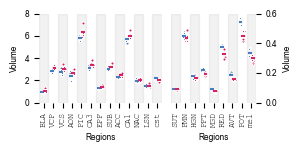

In [8]:
## Volume -- indiv plot
# Set plotting target
target = 'volume_mm3'
target_ylabel = 'Volume'
range_num=12
region_1=[{}]
region_2=[{}]
# Colors
ntg_color = blue
tg_color = red

# Prepare figure for plotting
plt.rcParams.update({'font.size': 6, 'font.family': 'Arial'})
plt.rcParams['text.usetex'] = False
plt.rcParams['svg.fonttype'] = 'none'  # Keep SVG text editable

fig, (ax, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(3, 1.5), gridspec_kw={'width_ratios': [13/9, 1]})
ax.set_frame_on(False)
ax2.set_frame_on(False)

# Plot background bands
for i in range(len(regions)):

        if i % 2 == 0:
            ax.axvspan(i + 0.5, i + 1.5, color='gray', alpha=0.1)
            ax2.axvspan(i + 0.5, i+ 1.5, color='gray', alpha=0.1)
            
# Plot data for each region
for i, region in enumerate(regions):
    tg_data = data[(data['Shorts'] == region) & (data['Gene_condition'] == 'AD')][target]
    ntg_data = data[(data['Shorts'] == region) & (data['Gene_condition'] == 'Non-AD')][target]

    tg_data_F = data[(data['Shorts'] == region) & (data['Gene_condition'] == 'AD') & (data['sex']=='F')][target]
    tg_data_M = data[(data['Shorts'] == region) & (data['Gene_condition'] == 'AD') & (data['sex']=='M')][target]
    ntg_data_F = data[(data['Shorts'] == region) & (data['Gene_condition'] == 'Non-AD')& (data['sex']=='F')][target]
    ntg_data_M = data[(data['Shorts'] == region) & (data['Gene_condition'] == 'Non-AD')& (data['sex']=='M')][target]
        
    if (i < range_num):
        region_1.append(region)
        jitter = lambda: random.uniform(-0.1, 0.1)

        # Plot NTg points
        ax.scatter([i + 0.85 + jitter() for _ in ntg_data_F], ntg_data_F,s=5,  marker='o', color=ntg_color, linewidths=0.75, edgecolor='w',
                   label='NTg' if i == 0 else "", alpha=1)

        ax.scatter([i + 0.85 + jitter() for _ in ntg_data_M], ntg_data_M,s=4,  marker='s', color=ntg_color, linewidths=0.75, edgecolor='w',
                   label='NTg' if i == 0 else "", alpha=1)

        # Plot Tg points
        ax.scatter([i + 1.15 + jitter() for _ in tg_data_F], tg_data_F,s=5, marker='o',color=tg_color,linewidths=0.75, edgecolor='w',
                   label='Tg' if i == 0 else "", alpha=1)
        ax.scatter([i + 1.15 + jitter() for _ in tg_data_M], tg_data_M,s=4, marker='s',color=tg_color,linewidths=0.75, edgecolor='w',
                       label='Tg' if i == 0 else "", alpha=1)    

        # Plot group means
        if len(ntg_data) > 0:
            ax.plot([i + 0.75, i + 0.95], [ntg_data.mean()] * 2, color=blue, linewidth=1.5)
        if len(tg_data) > 0:
            ax.plot([i + 1.05, i + 1.25], [tg_data.mean()] * 2, color=red, linewidth=1.5) 
    elif (i != 20) & (i<20):
        region_2.append(region)
        jitter = lambda: random.uniform(-0.1, 0.1)

        # Plot NTg points
        ax2.scatter([i-(range_num) + 0.85 + jitter() for _ in ntg_data_F], ntg_data_F,s=5,  marker='o', color=ntg_color, linewidths=0.75, edgecolor='w',
                   label='NTg' if i == 0 else "", alpha=1)

        ax2.scatter([i-(range_num)+ 0.85 + jitter() for _ in ntg_data_M], ntg_data_M,s=4,  marker='s', color=ntg_color, linewidths=0.75, edgecolor='w',
                   label='NTg' if i == 0 else "", alpha=1)

        # Plot Tg points
        ax2.scatter([i-(range_num) + 1.15 + jitter() for _ in tg_data_F], tg_data_F,s=5, marker='o',color=tg_color,linewidths=0.75, edgecolor='w',
                   label='Tg' if i == 0 else "", alpha=1)
        ax2.scatter([i-(range_num) + 1.15 + jitter() for _ in tg_data_M], tg_data_M,s=4, marker='s',color=tg_color,linewidths=0.75, edgecolor='w',
                       label='Tg' if i == 0 else "", alpha=1)    

        # Plot group means
        if len(ntg_data) > 0:
            ax2.plot([i-(range_num) + 0.75, i-(range_num) + 0.95], [ntg_data.mean()] * 2, color=blue, linewidth=1.5)
        if len(tg_data) > 0:
            ax2.plot([i-(range_num) + 1.05, i-(range_num) + 1.25], [tg_data.mean()] * 2, color=red, linewidth=1.5) 
    elif (i != 20) & (i>20):
            region_2.append(region)
            jitter = lambda: random.uniform(-0.1, 0.1)

            # Plot NTg points
            ax2.scatter([i-(range_num)-1 + 0.85 + jitter() for _ in ntg_data_F], ntg_data_F,s=5,  marker='o', color=ntg_color, linewidths=0.75, edgecolor='w',
                       label='NTg' if i == 0 else "", alpha=1)

            ax2.scatter([i-(range_num)-1+ 0.85 + jitter() for _ in ntg_data_M], ntg_data_M,s=4,  marker='s', color=ntg_color, linewidths=0.75, edgecolor='w',
                       label='NTg' if i == 0 else "", alpha=1)

            # Plot Tg points
            ax2.scatter([i-(range_num)-1 + 1.15 + jitter() for _ in tg_data_F], tg_data_F,s=5, marker='o',color=tg_color,linewidths=0.75, edgecolor='w',
                       label='Tg' if i == 0 else "", alpha=1)
            ax2.scatter([i-(range_num)-1 + 1.15 + jitter() for _ in tg_data_M], tg_data_M,s=4, marker='s',color=tg_color,linewidths=0.75, edgecolor='w',
                           label='Tg' if i == 0 else "", alpha=1)    

            # Plot group means
            if len(ntg_data) > 0:
                ax2.plot([i-(range_num)-1 + 0.75, i-(range_num)-1 + 0.95], [ntg_data.mean()] * 2, color=blue, linewidth=1.5)
            if len(tg_data) > 0:
                ax2.plot([i-(range_num)-1 + 1.05, i-(range_num)-1 + 1.25], [tg_data.mean()] * 2, color=red, linewidth=1.5) 
        
    else:
        region_1.append(region)
        jitter = lambda: random.uniform(-0.1, 0.1)
        # Plot NTg points
        ax.scatter([len(region_1)-2 + 0.85 + jitter() for _ in ntg_data_F], ntg_data_F,s=5,  marker='o', color=ntg_color, linewidths=0.75, edgecolor='w',
                   label='NTg' if i == 0 else "", alpha=1)

        ax.scatter([len(region_1)-2+ 0.85 + jitter() for _ in ntg_data_M], ntg_data_M,s=4,  marker='s', color=ntg_color, linewidths=0.75, edgecolor='w',
                   label='NTg' if i == 0 else "", alpha=1)

        # Plot Tg points
        ax.scatter([len(region_1)-2 + 1.15 + jitter() for _ in tg_data_F], tg_data_F,s=5, marker='o',color=tg_color,linewidths=0.75, edgecolor='w',
                   label='Tg' if i == 0 else "", alpha=1)
        ax.scatter([len(region_1)-2 + 1.15 + jitter() for _ in tg_data_M], tg_data_M,s=4, marker='s',color=tg_color,linewidths=0.75, edgecolor='w',
                       label='Tg' if i == 0 else "", alpha=1)    

        # Plot group means
        if len(ntg_data) > 0:
            ax.plot([len(region_1)-2+ 0.75, len(region_1)-2 + 0.95], [ntg_data.mean()] * 2, color=blue, linewidth=1.5)
        if len(tg_data) > 0:
            ax.plot([len(region_1)-2 + 1.05, len(region_1)-2 + 1.25], [tg_data.mean()] * 2, color=red, linewidth=1.5) 
        
# Customize plot appearance
ax.set_xticks(np.arange(len(region_1)))
ax.set_xticklabels(region_1, rotation=90,fontname='Courier New')
ax.set_xlabel('Regions')
ax.set_ylabel(target_ylabel)
ax.set_xlim(0.5,13.5)
ax.set_ylim(0,8)

ax2.set_xticks(np.arange(len(region_2)))
ax2.set_xticklabels(region_2, rotation=90,fontname='Courier New')
ax2.set_xlabel('Regions')
ax2.set_ylabel(target_ylabel)
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()
ax2.set_xlim(0.5,9.5)
ax2.set_ylim(0,0.6)

# Save the figure
save_path_fig=os.path.join(save_path,"Indiv_Volumemm3_Mean_Dots_2025_11_04.svg")
plt.savefig(save_path_fig, dpi=600)

# Display plot
plt.tight_layout()
plt.show()

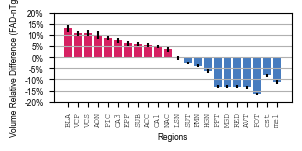

In [9]:
## Volume -- groups
relative_diff = []
relative_diff_sem = []

for i, region in enumerate(regions):
    # Filter data for AD and Non-AD groups for the current region
    ad_data = data[(data['Shorts'] == region) & (data['Gene_condition'] == 'AD')]['volume_mm3']
    non_ad_data = data[(data['Shorts'] == region) & (data['Gene_condition'] == 'Non-AD')]['volume_mm3']

    ad_mean = np.mean(ad_data)
    non_ad_mean = np.mean(non_ad_data)

    if non_ad_mean != 0:  # Avoid division by zero
        relative_diff.append((ad_mean - non_ad_mean) / non_ad_mean)
    
        combined_data = []
        num = np.array(ad_data)
        denom = np.array(non_ad_data)
        for i in range(len(denom)):
            combined_data.append(num/denom[i])

        temp=np.array(combined_data) 
        relative_diff_sem.append(np.std(temp)/(np.sqrt(len(num)*len(denom))))
    else:
        relative_diff.append(np.nan)  # Handle zero denominator case

plt.rcParams['svg.fonttype'] = 'none'  # Keep SVG text editable
        
# Define figure and axes for plotting
fig, ax = plt.subplots(figsize=(3, 1.5))

# Plot the relative difference
    
ax.bar(regions[0:11], relative_diff[0:11], color=red,yerr=relative_diff_sem[0:11])
ax.bar(regions[11], relative_diff[11], color='grey',yerr=relative_diff_sem[11])
ax.bar(regions[12:], relative_diff[12:], color=blue,yerr=relative_diff_sem[12:])

ax.grid(axis='y',zorder=0)

# Customize plot appearance
ax.set_xticks(np.arange(len(regions)))

ax.set_ylim(-.20,.20)

lin_dat=np.linspace(-.20,.20,9)
lin_dat_formatted=[]
for lin in lin_dat:
    lin_dat_formatted.append(f"{lin:.0%}")
ax.set_yticks(lin_dat)
ax.set_yticklabels(lin_dat_formatted,fontsize=6, fontname='Arial')

ax.set_xticklabels(regions, rotation=90, fontsize=6, fontname='Courier New')
ax.set_xlabel('Regions', fontsize=6, fontname='Arial')
ax.set_ylabel('Volume Relative Difference (FAD-nTg)/nTg', fontsize=6, fontname='Arial')

save_path_fig=os.path.join(save_path,"Volume_relative_mean_diff_AD_non_AD.svg")
plt.savefig(save_path_fig, dpi=600)

# Display plot
plt.tight_layout()
plt.show()

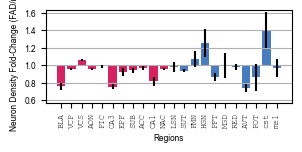

In [10]:
## Neuron Density -- groups
relative_diff = []
relative_diff_sem = []
for i, region in enumerate(regions):
    # Filter data for AD and Non-AD groups for the current region
    ad_data = data[(data['Shorts'] == region) & (data['Gene_condition'] == 'AD')]['NeuNDensity_Mean']
    non_ad_data = data[(data['Shorts'] == region) & (data['Gene_condition'] == 'Non-AD')]['NeuNDensity_Mean']

    ad_mean = np.mean(ad_data)
    non_ad_mean = np.mean(non_ad_data)

    if non_ad_mean != 0:  # Avoid division by zero
        #relative_diff.append((ad_mean - non_ad_mean) / non_ad_mean)
        relative_diff.append((ad_mean / non_ad_mean)-1)
        
        combined_data = []
        num = np.array(ad_data)
        denom = np.array(non_ad_data)
        for i in range(len(denom)):
            combined_data.append(num/denom[i])

        temp=np.array(combined_data)   
        relative_diff_sem.append(np.std(temp)/(np.sqrt(len(num)*len(denom))))
        #relative_diff_sem.append(sem(temp.reshape(1, -1), nan_policy='omit'))
    else:
        relative_diff.append(np.nan)  # Handle zero denominator case

plt.rcParams['svg.fonttype'] = 'none'  # Keep SVG text editable
# Define figure and axes for plotting
fig, ax = plt.subplots(figsize=(3, 1.5))

# Plot the relative difference
ax.bar(regions[0:11], relative_diff[0:11], color=red,bottom=1,yerr=relative_diff_sem[0:11])
ax.bar(regions[11], relative_diff[11], color='grey',bottom=1,yerr=relative_diff_sem[11])
ax.bar(regions[12:], relative_diff[12:], color=blue,bottom=1,yerr=relative_diff_sem[12:])
ax.grid(axis='y')

# Customize plot appearance
ax.set_xticks(np.arange(len(regions)))

ax.set_ylim(0.6*0.95,1.6+(0.6-0.6*0.95))

lin_dat=np.linspace(0.6,1.6,11)
selected_lin_dat=np.round(lin_dat[list(range(0, 11, 2))],1)
ax.set_yticks(selected_lin_dat)
ax.set_yticklabels(selected_lin_dat,fontsize=6, fontname='Arial')

ax.set_xticklabels(regions, rotation=90, fontsize=6, fontname='Courier New')
ax.set_xlabel('Regions', fontsize=6, fontname='Arial')
ax.set_ylabel('Neuron Density Fold-Change (FAD/nTg)', fontsize=6, fontname='Arial')

save_path_fig=os.path.join(save_path,"Neuron_Density_FoldChange_AD_non_AD.svg")
plt.savefig(save_path_fig, dpi=600)

# Display plot
plt.tight_layout()
plt.show()

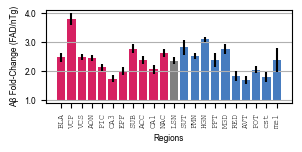

In [11]:
## Abeta Density -- groups
relative_diff = []
relative_diff_sem = []
for i, region in enumerate(regions):
    # Filter data for AD and Non-AD groups for the current region
    ad_data = data[(data['Shorts'] == region) & (data['Gene_condition'] == 'AD')]['Abeta_Mean']
    non_ad_data = data[(data['Shorts'] == region) & (data['Gene_condition'] == 'Non-AD')]['Abeta_Mean']


    ad_mean = np.mean(ad_data)
    non_ad_mean = np.mean(non_ad_data)


    if non_ad_mean != 0:  # Avoid division by zero
        relative_diff.append((ad_mean / non_ad_mean)-1)
        
        combined_data = []
        num = np.array(ad_data)
        denom = np.array(non_ad_data)
        for i in range(len(denom)):
            combined_data.append(num/denom[i])

        temp=np.array(combined_data) 
        relative_diff_sem.append(np.std(temp)/(np.sqrt(len(num)*len(denom))))
    else:
        relative_diff.append(np.nan)  # Handle zero denominator case

plt.rcParams['svg.fonttype'] = 'none'  # Keep SVG text editable
# Define figure and axes for plotting
fig, ax = plt.subplots(figsize=(3, 1.5))

# Plot the relative difference
ax.bar(regions[0:11], relative_diff[0:11], color=red,bottom=1,yerr=relative_diff_sem[0:11])
ax.bar(regions[11], relative_diff[11], color='grey',bottom=1,yerr=relative_diff_sem[11])
ax.bar(regions[12:], relative_diff[12:], color=blue,bottom=1,yerr=relative_diff_sem[12:])
ax.grid(axis='y',zorder=0)

# Customize plot appearance
ax.set_xticks(np.arange(len(regions)))
ax.set_ylim(1*0.9,4*(1+0.1/4))


lin_dat=np.linspace(1,4,4)
ax.set_yticks(lin_dat)
ax.set_yticklabels(lin_dat,fontsize=6, fontname='Arial')
ax.set_xticklabels(regions, rotation=90, fontsize=6, fontname='Courier New')
ax.set_xlabel('Regions', fontsize=6, fontname='Arial')
ax.set_ylabel('Aβ Fold-Change (FAD/nTg)', fontsize=6, fontname='Arial')

save_path_fig=os.path.join(save_path,"Abeta_FoldChange_AD_non_AD.svg")
plt.savefig(save_path_fig, dpi=600)

# Display plot
plt.tight_layout()
plt.show()

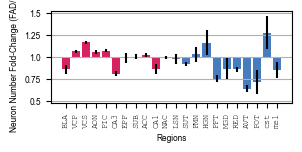

In [12]:
## Neuron Number -- groups
relative_diff = []
relative_diff_sem = []
for i, region in enumerate(regions):
    # Filter data for AD and Non-AD groups for the current region
    ad_data = data[(data['Shorts'] == region) & (data['Gene_condition'] == 'AD')]['NeuN_num']
    non_ad_data = data[(data['Shorts'] == region) & (data['Gene_condition'] == 'Non-AD')]['NeuN_num']


    ad_mean = np.mean(ad_data)
    non_ad_mean = np.mean(non_ad_data)


    if non_ad_mean != 0:  # Avoid division by zero
        #relative_diff.append((ad_mean - non_ad_mean) / non_ad_mean)
        relative_diff.append((ad_mean / non_ad_mean)-1)
        combined_data = []
        num = np.array(ad_data)
        denom = np.array(non_ad_data)
        for i in range(len(denom)):
            combined_data.append(num/denom[i])

        temp=np.array(combined_data) 
        relative_diff_sem.append(np.std(temp)/(np.sqrt(len(num)*len(denom))))
    else:
        relative_diff.append(np.nan)  # Handle zero denominator case

plt.rcParams['svg.fonttype'] = 'none'  # Keep SVG text editable
# Define figure and axes for plotting
fig, ax = plt.subplots(figsize=(3,1.5))

# Plot the relative difference
ax.bar(regions[0:11], relative_diff[0:11], color=red,bottom=1,yerr=relative_diff_sem[0:11])
ax.bar(regions[11], relative_diff[11], color='grey',bottom=1,yerr=relative_diff_sem[11])
ax.bar(regions[12:], relative_diff[12:], color=blue,bottom=1,yerr=relative_diff_sem[12:])
ax.grid(axis='y',zorder=0)

# Customize plot appearance
ax.set_xticks(np.arange(len(regions)))
ax.set_ylim(0.5*0.95,1.5+(0.5-0.5*0.95))

lin_dat=np.linspace(0.5,1.5,5)
ax.set_yticks(lin_dat)
ax.set_yticklabels(lin_dat,fontsize=6, fontname='Arial')

#ax.set_xticklabels(adjusted_region, rotation=90, fontsize=6, fontname='Courier New')
ax.set_xticklabels(regions, rotation=90, fontsize=6, fontname='Courier New')
ax.set_xlabel('Regions', fontsize=6, fontname='Arial')
ax.set_ylabel('Neuron Number Fold-Change (FAD/nTg)', fontsize=6, fontname='Arial')

save_path_fig=os.path.join(save_path,"Neuron_Number_FoldChange_AD_non_AD.svg")
plt.savefig(save_path_fig, dpi=600)

# Display plot
plt.tight_layout()
plt.show()

In [13]:
# Grab increase and decrease regions associated with Volume mm3 -- no tracts included -- removing regions where the abs (% change) <1%
val=df[df['Contrast']=='volume_mm3']['Relative_Diff wrt nTG']>0.01
true_indices = [i for i, val in enumerate(val) if val is True]
val=df[df['Contrast']=='volume_mm3']['Relative_Diff wrt nTG']<-0.01
false_indices = [i for i, val in enumerate(val) if val is True]

region_increase=[]
region_decrease=[]

for i, true_idx in enumerate(true_indices):
    if regions[true_indices[i]].isupper():
        region_increase.append(regions[true_indices[i]])
for i, decrease_idx in enumerate(false_indices):
    if regions[false_indices[i]].isupper():
        region_decrease.append(regions[false_indices[i]])
        
        
custom_regions = {
    'Increase': region_increase,  
    'Decrease': region_decrease
}

print(custom_regions)

{'Increase': ['BLA', 'VCP', 'VCS', 'AON', 'PIC', 'CA3', 'EPF', 'SUB', 'ACC', 'CA1', 'NAC'], 'Decrease': ['SUT', 'FMN', 'HGN', 'PFT', 'MGD', 'RED', 'AVT', 'POT']}


In [14]:
#set region lists how actually desired for processing which is telecephalon v brainstem/thalamus

Telencephalon=['BLA', 'VCP', 'VCS','AON','PIC','CA3', 'EPF','SUB','ACC','CA1','NAC','LSN','cst']
Brainstem=['SUT','FMN','HGN','PFT','MGD','RED','AVT','POT','mel']

custom_regions = {
    'Telencephalon': Telencephalon,  
    'Brainstem': Brainstem
}

print(custom_regions)

{'Telencephalon': ['BLA', 'VCP', 'VCS', 'AON', 'PIC', 'CA3', 'EPF', 'SUB', 'ACC', 'CA1', 'NAC', 'LSN', 'cst'], 'Brainstem': ['SUT', 'FMN', 'HGN', 'PFT', 'MGD', 'RED', 'AVT', 'POT', 'mel']}


In [15]:
#Shape Pvalues into useful form and find the Fisher combined pvalues
data_keep_combined = [{}]

metrics = {
    'NeuN_num': 'Neuron number',
    'Abeta_Mean': 'Amyloid beta load',
    'NeuNDensity_Mean': 'Neuron density',
    'volume_mm3': 'Volume'
}

categories=['Telencephalon','Brainstem']

for metric, metric_name in metrics.items(): 
    for i,category in enumerate(categories):
        pvalue=[]
        pvalue_BH=[]
        if category == 'Telencephalon':
            for i, ri in enumerate(Telencephalon):
                
                pvalue.append(df[(df['Abbreviation'] == ri) & (df['Contrast'] == metric)]['Pvalue'])
                pvalue_BH.append(df[(df['Abbreviation'] == ri) & (df['Contrast'] == metric)]['Pvalue_BH'])
                
        elif category == 'Brainstem':
            for i, rd in enumerate(Brainstem):
                pvalue.append(df[(df['Abbreviation'] == rd) & (df['Contrast'] == metric)]['Pvalue'])
                pvalue_BH.append(df[(df['Abbreviation'] == rd) & (df['Contrast'] == metric)]['Pvalue_BH'])    

        entry={'Contrast': metric,'Category':category,'Fisher_Combined_Pvalue':fisher_combined(pvalue)}
        data_keep_combined.append(entry)

df_combo = pd.DataFrame(data_keep_combined)
df_combo = df_combo[1:] #cleans out preallocation row


save_path_data=os.path.join(save_path,"Combined_Pvalue_Results_for_Figure6_cstinTelencephalon.csv")
df_combo.to_csv(save_path_data, index=True)

In [16]:
#Do corrleation just of the FAD specimens Regionally
file_path=os.path.join(data_folder_path,"Archive_NeuN_Abeta_Volume_Dec19_removeextrasub.xlsx")   
df = pd.read_excel(file_path, sheet_name='Archive_NeuN_Abeta_Volume_Dec19')

val=df['Structure']=='cn7__Facial_motor_nucleus_cranial_nerve_VII_left'
true_indices = [i for i, val in enumerate(val) if val is True]

for i, true_idx in enumerate(true_indices):
    df.loc[true_indices[i], 'Structure']='FMN__Facial_motor_nucleus_left'
    
df = df.rename(columns={
    'NeuNDensity_Mean (*1000)': 'Neuron_Density',
    'NeuN_num_Mean': 'Neuron_Number',
    'volume_mm3': 'Volume',
    'Abeta_Mean': 'Abeta_load'
})

FAD_df=df[df['Gene_condition']=='Tg']
NTg_df=df[df['Gene_condition']=='nTg'] #might as well just have

ROI_values=FAD_df['Region'].unique()

# Compute correlations
x_metric='Abeta_load'
x_compare='A Beta Load in FAD'

y_metric=['volume_normalized', 'Volume', 'Neuron_Density', 'Neuron_Number']
y_compare = ['Fractional Volume in FAD','Volume in FAD', 'Neuron Density in FAD', 'Neuron Number in FAD']


data_out=[{}]
for roi in ROI_values:
    temp_FAD_df=FAD_df[FAD_df['Region']==roi]
    structure_name = temp_FAD_df['Structure'].unique()
    valf=regions_num==roi
    true_indices =np.where(valf)
    
    for i in range(4):
        entry=correlation(temp_FAD_df[x_metric],temp_FAD_df[y_metric[i]],x_compare,y_compare[i],'spearman','-')
        entry.update({'ROI': roi,'Structure':str("").join(structure_name),'Figure X-Position Index': str(true_indices[0]+1)})
        data_out.append(entry)
        
df_out = pd.DataFrame(data_out)
df_out = df_out[1:] #cleans out preallocation row

H0, Pvalue_BH,Sidak_Alpha,Bonferroni_Alpha=multipletests(df_out['pvalue'], alpha=0.05, method='fdr_bh')
df_out.insert(loc=6, column='Pvalue_BH', value=Pvalue_BH)
H0, Pvalue_Bonferroni,Sidak_Alpha,Bonferroni_Alpha=multipletests(df_out['pvalue'], alpha=0.05, method='bonferroni')
df_out.insert(loc=6, column='Pvalue_Bonferroni', value=Pvalue_Bonferroni)

save_path_data=os.path.join(save_path,"Lightsheet_Regional_Correlation_onlyFAD_spearman.csv")
df_out.to_csv(save_path_data, index=True)

In [17]:
df_out.head()

,x_metric,y_metric,additional_delineation,correlation type,rho,pvalue,Pvalue_Bonferroni,Pvalue_BH,ROI,Structure,Figure X-Position Index
1,A Beta Load in FAD,Fractional Volume in FAD,-,spearman,0.350000,0.355820,1.000000,0.559145,4.0,AON__Anterior_olfactory_nucleus_left,[4]
2,A Beta Load in FAD,Volume in FAD,-,spearman,0.183333,0.636820,1.000000,0.767673,4.0,AON__Anterior_olfactory_nucleus_left,[4]
3,A Beta Load in FAD,Neuron Density in FAD,-,spearman,0.800000,0.009628,0.847257,0.084726,4.0,AON__Anterior_olfactory_nucleus_left,[4]
4,A Beta Load in FAD,Neuron Number in FAD,-,spearman,0.666667,0.049867,1.000000,0.230964,4.0,AON__Anterior_olfactory_nucleus_left,[4]
5,A Beta Load in FAD,Fractional Volume in FAD,-,spearman,-0.400000,0.286105,1.000000,0.503545,9.0,ACC__Anterior_cingulate_cortex_left,[9]


In [18]:
roi_telencephalic=[41,25,26,4,12,32,45,28,9,31,48,55,168]
roi_thalamus_brainstem=[99,126,151,74,79,110,61,78,169]

y_compare = ['Fractional Volume in FAD','Volume in FAD', 'Neuron Density in FAD', 'Neuron Number in FAD']

for n in range(4): 
    df_telencephalic=[{}]
    correlation_telencephalic=[{}]
    df_thalamus_brainstem=[{}]
    correlation_thalamus_brainstem=[{}]
    
    for i, single_roi in enumerate(roi_telencephalic):
        temp=df_out[(df_out['ROI']==roi_telencephalic[i]) & (df_out['y_metric']==y_compare[n])].reset_index()
        for true_idx in range(temp.shape[0]):
            entry={'pvalue': temp.loc[true_idx,'pvalue']}
            df_telencephalic.append(entry) 
            entry={'rho': temp.loc[true_idx,'rho']}
            correlation_telencephalic.append(entry)
            
    for i, single_roi in enumerate(roi_thalamus_brainstem):
        temp=df_out[(df_out['ROI']==roi_thalamus_brainstem[i])& (df_out['y_metric']==y_compare[n])].reset_index()
        for true_idx in range(temp.shape[0]):
            entry={'pvalue': temp.loc[true_idx,'pvalue']}
            df_thalamus_brainstem.append(entry)
            entry={'rho': temp.loc[true_idx,'rho']}
            correlation_thalamus_brainstem.append(entry)

    
    DF_C_T = pd.DataFrame(correlation_telencephalic)
    DF_C_T = DF_C_T[1:]

    DF_C_T_BS = pd.DataFrame(correlation_thalamus_brainstem)
    DF_C_T_BS = DF_C_T_BS[1:]
    
    #print(len(df_telencephalic))
    DF_out_T = pd.DataFrame(df_telencephalic)
    DF_out_T = DF_out_T[1:]
    
    #print(len(df_thalamus_brainstem))
    DF_out_T_BS = pd.DataFrame(df_thalamus_brainstem)
    DF_out_T_BS = DF_out_T_BS[1:]
    
    # do these two groups differ (not a look at all the pvalues and pull meaning)... then don't do BH correction... just work on the regular Pvalues
    
    print(f"Summary of {y_compare[n]} correlated with A Beta Load in FAD")
    print('\n')
    print(f"Fisher Combined P Value thalamus_brainstem: {fisher_combined(DF_out_T_BS['pvalue'])}")
    print(f"Average Rho thalamus_brainstem: {DF_C_T_BS['rho'].mean()}")
    print(f"SEM Rho thalamus_brainstem: {DF_C_T_BS['rho'].std()/math.sqrt(len(roi_thalamus_brainstem))}")
    print('\n')
    print(f"Fisher Combined P Value telencephalic: {fisher_combined(DF_out_T['pvalue'])}")
    print(f"Average Rho telencephalic: {DF_C_T['rho'].mean()}")
    print(f"SEM Rho telencephalic: {DF_C_T['rho'].std()/math.sqrt(len(roi_telencephalic))}")
    print('\n\n')

Summary of Fractional Volume in FAD correlated with A Beta Load in FAD


Fisher Combined P Value thalamus_brainstem: 0.31387142895749326
Average Rho thalamus_brainstem: -0.32222222222222224
SEM Rho thalamus_brainstem: 0.07728015412913086


Fisher Combined P Value telencephalic: 0.21827612080138156
Average Rho telencephalic: 0.006410256410256421
SEM Rho telencephalic: 0.11430046220706856



Summary of Volume in FAD correlated with A Beta Load in FAD


Fisher Combined P Value thalamus_brainstem: 0.4067101274799538
Average Rho thalamus_brainstem: -0.23333333333333334
SEM Rho thalamus_brainstem: 0.09742043287083435


Fisher Combined P Value telencephalic: 0.0871266860191193
Average Rho telencephalic: 0.05384615384615384
SEM Rho telencephalic: 0.1234758048400162



Summary of Neuron Density in FAD correlated with A Beta Load in FAD


Fisher Combined P Value thalamus_brainstem: 0.0002416115796839816
Average Rho thalamus_brainstem: 0.5333333333333333
SEM Rho thalamus_brainstem: 0.091244820586